<a href="https://colab.research.google.com/github/patelpujan47/Forecasting_Arima_Walmart_car_count/blob/main/Forecasting_ARIMA_Poojan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forcasting - ARIMA

## Libraries


In [89]:
import numpy as np
import pandas as pd
import math as m
import random
import statistics as stat
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


## Import Data

In [90]:
filename = "C:\WinData\Personal_Projects\Forecasting_Arima_Walmart_car_count\carcount.csv"
df = pd.DataFrame(pd.read_csv(filename))
df.head()

,date,day.of.week,car.count,weather,cloud.indicator
0,2010-01-01,Friday,101,0.1,clear
1,2010-01-02,Saturday,34,0.2,cloudy
2,2010-01-03,Sunday,113,0.4,clear
3,2010-01-04,Monday,5,0.6,cloudy
4,2010-01-05,Tuesday,124,0.1,clear


In [91]:
df.shape

(2373, 5)

In [92]:
df.dtypes

date                object
day.of.week         object
car.count            int64
weather            float64
cloud.indicator     object
dtype: object

In [93]:
df.rename(columns={"day.of.week":"day_of_week","car.count":"car_count", "cloud.indicator":"cloud_ind"}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df.dtypes

date           datetime64[ns]
day_of_week            object
car_count               int64
weather               float64
cloud_ind              object
dtype: object

## Exploratory Data Analysis (EDA)

In [94]:
df.isnull().value_counts()

date   day_of_week  car_count  weather  cloud_ind
False  False        False      False    False        2373
Name: count, dtype: int64

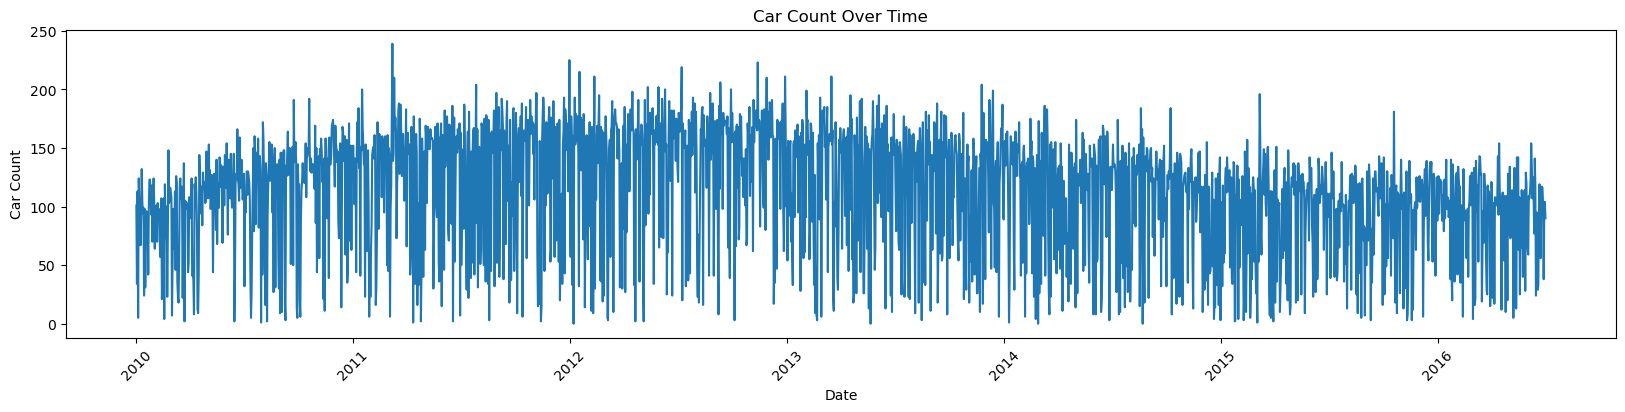

In [95]:
# Plot car count
plt.figure(figsize=(20,4))
plt.plot(df["date"], df["car_count"])
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Car Count")
plt.title("Car Count Over Time")
plt.show()

There is strong trend throughout the data with extreme fluctuations - No particularly trend or any seasonality within yearly data

Slight upward trend from 2010 to 2012 - stable from 2012 t 2013 - slight downward trend from 2013 to 2016

Need to look closer at the data using a shorter time frame - just 2014 to 2016


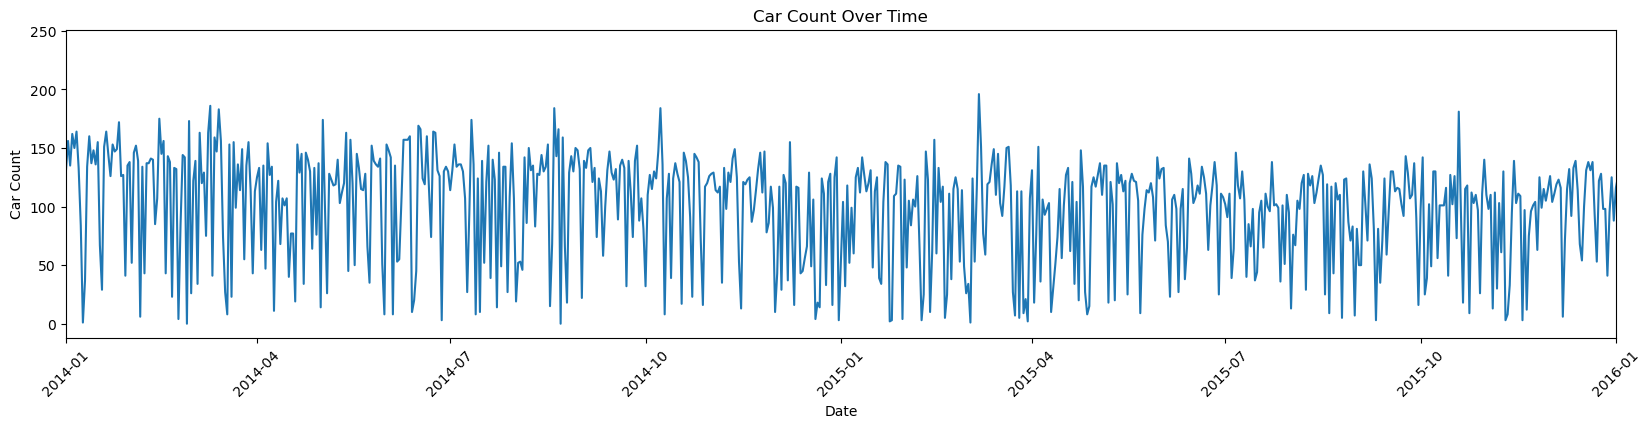

In [96]:
start_date = datetime(2014,1,1)
end_date = datetime(2016,1,1)

plt.figure(figsize=(20,4))
plt.plot(df["date"], df["car_count"])
plt.xlabel("Date")
plt.xlim(start_date, end_date)
plt.xticks(rotation=45)
plt.ylabel("Car Count")
plt.title("Car Count Over Time")
plt.show()

Still to much variation - need to see if any of our indicators are responsible for it
Weather - possible but not likely as people still shop
Cloud indicator - possible as accuracy of data is affected based on cloud conditions - lets scatterplot for this

In [97]:
cloudy_data = df.loc[df["cloud_ind"] == "cloudy"]
clear_data = df.loc[df["cloud_ind"] == "clear"]


### Impact of Cloud Indicator

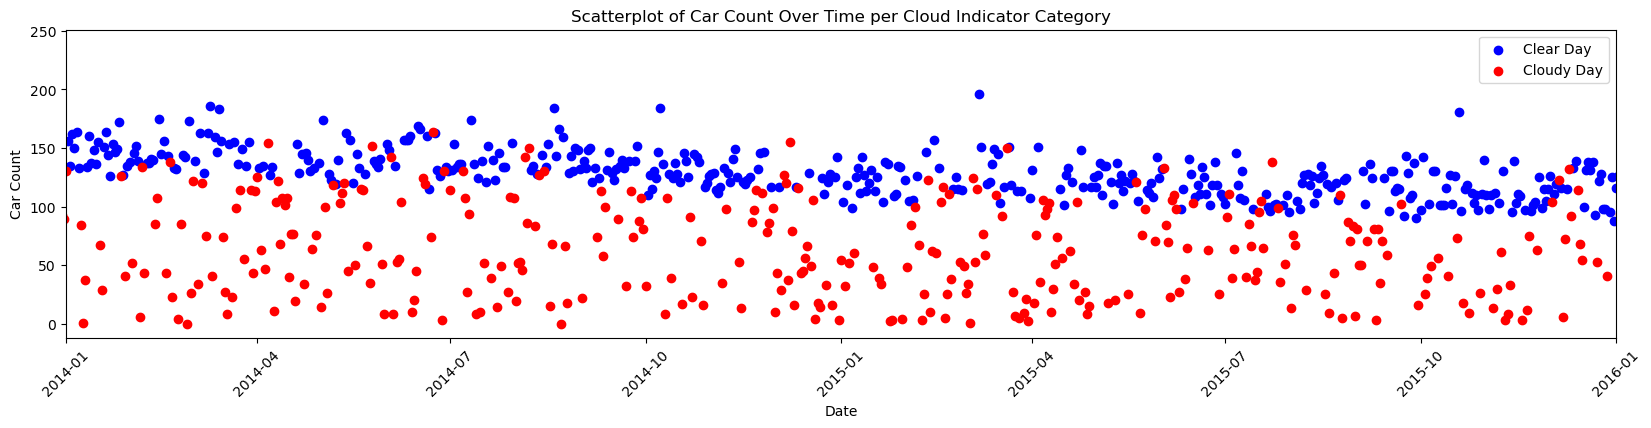

In [98]:
plt.figure(figsize=(20,4))
plt.scatter(clear_data["date"], clear_data["car_count"], color = 'blue')
plt.scatter(cloudy_data["date"], cloudy_data["car_count"], color = 'red')
plt.legend(['Clear Day', 'Cloudy Day'])
plt.xlabel("Date")
plt.xlim(start_date, end_date)
plt.ylabel("Car Count")
plt.xticks(rotation=45)
plt.title("Scatterplot of Car Count Over Time per Cloud Indicator Category")
plt.show()

Clearly - high variablity when its cloud - most likely due to difficulty in reading the aerial image on cloudy days
Consider all cloudy day data as unreliable

### Impact of Weather Variable

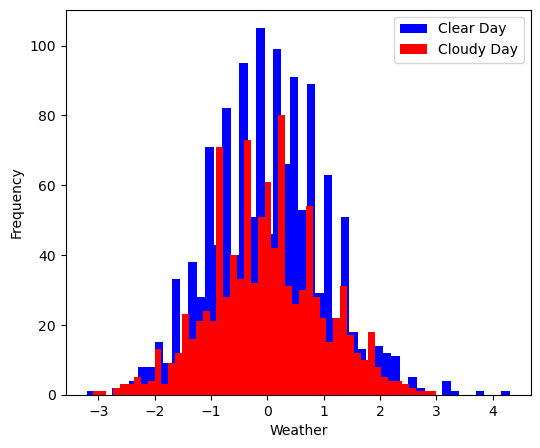

In [99]:
plt.figure(figsize=(6,5))
plt.hist(clear_data["weather"], bins= 50, color = 'blue')
plt.hist(cloudy_data["weather"], bins= 50, color = 'red')
plt.legend(['Clear Day', 'Cloudy Day'])
plt.xlabel("Weather")
plt.ylabel("Frequency")
plt.show()

Since weather data is normalized - clear days are more likely to have lower absolute weather value

### Correlation between Cloud Indicator and Weather

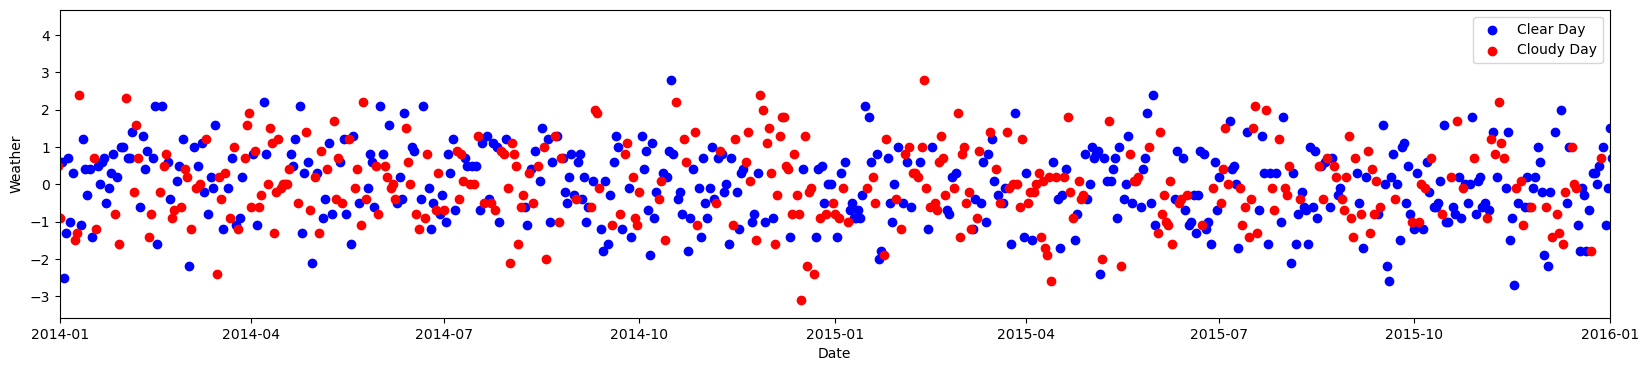

In [100]:
plt.figure(figsize=(20,4))
plt.scatter(clear_data["date"], clear_data["weather"], color = 'blue')
plt.scatter(cloudy_data["date"], cloudy_data["weather"], color = 'red')
plt.legend(['Clear Day', 'Cloudy Day'])
plt.xlabel('Date')
plt.xlim(start_date, end_date)
plt.ylabel('Weather')
plt.xticks(rotation=0) 
plt.show()

No correlation between Weather and Cloud Indicator

### Outliers

Outlier analysis: if we keep all of the data (including from cloudy days), this will produce a misleading IQR
only use clear days data

In [101]:
clear_data["year"] = clear_data["date"].dt.year

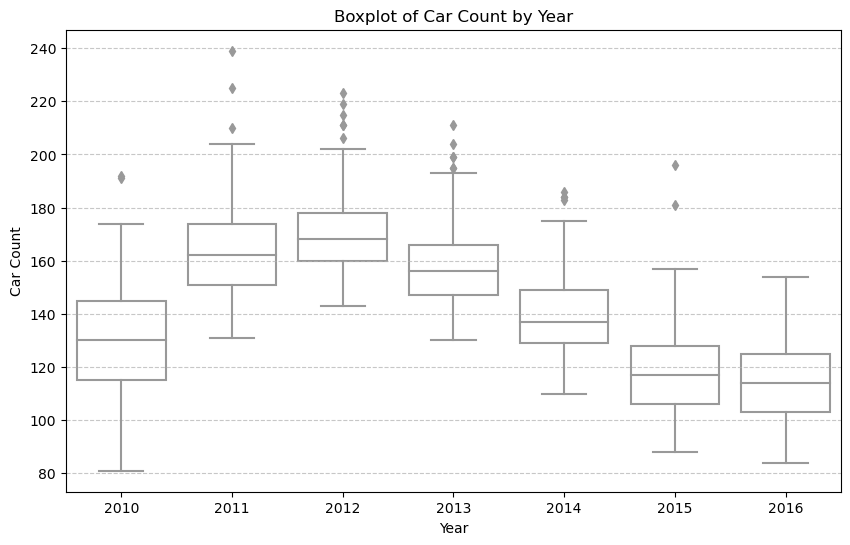

In [102]:
plt.figure(figsize=(10,6))
sns.boxplot(data = clear_data, x = "year", y = "car_count", color="w")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.title('Boxplot of Car Count by Year')
plt.xlabel('Year')
plt.ylabel('Car Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()


Difficult to say what actually are outliers as we can observe some days with high car count due to any events - need more information to consider them outliers

### Day of Week

In [103]:
day_car_count_clear = clear_data.groupby('day_of_week')['car_count'].sum()

day_car_count_clear.head()

day_of_week
Friday      29911
Monday      28272
Saturday    29237
Sunday      27514
Thursday    25990
Name: car_count, dtype: int64

In [104]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


day_car_count_clear = day_car_count_clear.reindex(days_order)

day_car_count_clear.head()

day_of_week
Monday       28272
Tuesday      27088
Wednesday    26565
Thursday     25990
Friday       29911
Name: car_count, dtype: int64

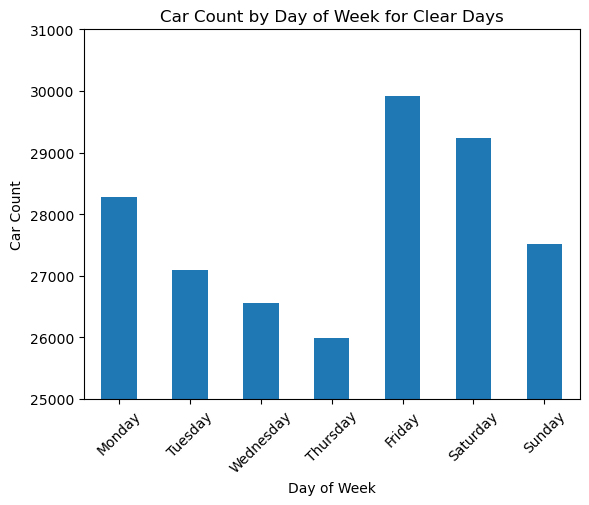

In [105]:
day_car_count_clear.plot(kind='bar')
plt.title('Car Count by Day of Week for Clear Days')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.ylabel('Car Count')
plt.ylim(25000, 31000)
plt.show()


Going downwards as weekdays progresses and then high on Weekends particularly Friday Saturday
Could be useful feature


## ARIMA Model

### Stationarity

ARIMA needs stationary data (constant mean/variance over time)

In [106]:
test_stationarity = adfuller(clear_data["car_count"], autolag='AIC')

print(f"Test Statistic: {test_stationarity[0]}")
print(f"p-value: {test_stationarity[1]}")
print(f"Lag: {test_stationarity[2]}")
print(f"Observations: {test_stationarity[3]}")
print(f"Critical Value: {test_stationarity[4]}")

Test Statistic: -1.5446758411590522
p-value: 0.5113065742932866
Lag: 20
Observations: 1332
Critical Value: {'1%': -3.435268879033529, '5%': -2.8637122982329517, '10%': -2.5679265381823266}


Null Hypothesis: The time series has a unit root, meaning it is non-stationary

Alternate Hypothesis: The time series does NOT have a unit root, meaning it is stationary

The test statistic is not lower than the 5% or 1% critical values, and the p-value > 0.05, so we fail to reject the null hypothesis - Data is not stationary 

Need Some Transformations - try first order differencing

In [107]:
clear_data["diff"] = clear_data["car_count"].diff(periods=1)


In [108]:
test_stationarity_diff = adfuller(clear_data["diff"].dropna(inplace=False), autolag='AIC')

print(f"Test Statistic: {test_stationarity_diff[0]}")
print(f"p-value: {test_stationarity_diff[1]}")
print(f"Lag: {test_stationarity_diff[2]}")
print(f"Observations: {test_stationarity_diff[3]}")
print(f"Critical Value: {test_stationarity_diff[4]}")

Test Statistic: -10.903577665145239
p-value: 1.1429562824473675e-19
Lag: 24
Observations: 1327
Critical Value: {'1%': -3.435287448902869, '5%': -2.8637204923840334, '10%': -2.5679309018875833}


### Plot ACF and PACF

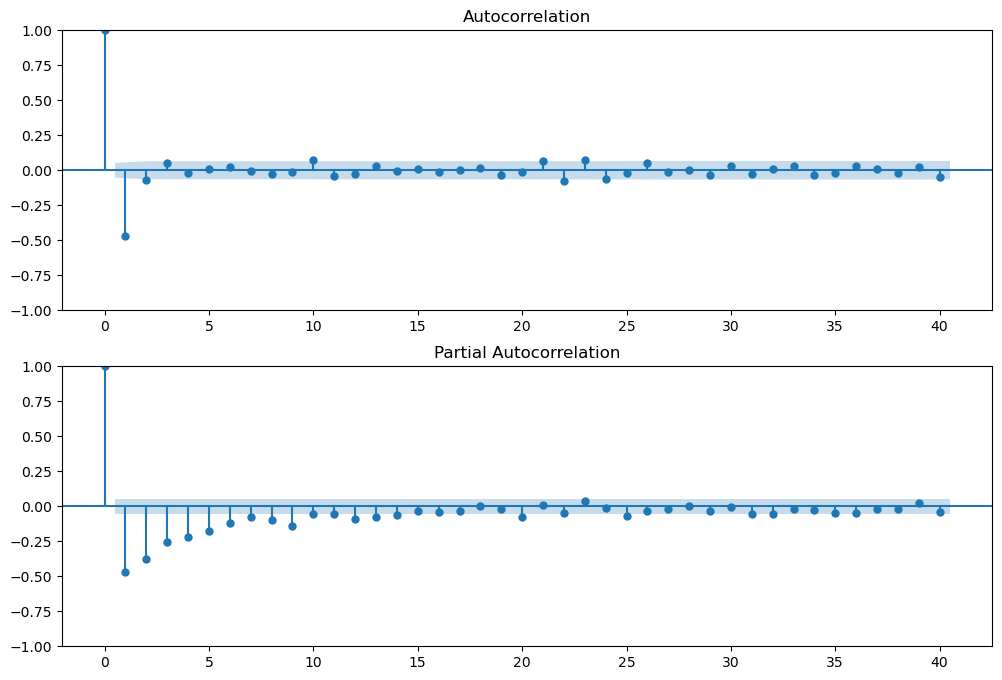

In [109]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(clear_data['diff'][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(clear_data['diff'][1:], lags=40, ax=ax2) # first value of diff is Na

ACF (Top Plot) – Autocorrelation:
Big spike at lag 1, then cuts off quickly — this suggests a low MA (q) component.
Since there's no gradual decay, and lags beyond 1 are within the confidence interval → likely q = 1.

PACF (Bottom Plot) – Partial Autocorrelation:
A strong spike at lag 1, smaller ones up to lag 5-6, then dies down.
This pattern often suggests AR (p) = 1 to 5, depending on how many lags are significantly above the blue bounds.

p = 1 to 5, d = 1 (diff is 1), q = 1


### Model Fitting

In [ ]:
# Arima requires inputs to be floats for differencing and parameter estimations and optimization

clear_data['car_count_float']= clear_data['car_count'].astype(float)

clear_data.head()

,date,day_of_week,car_count,weather,cloud_ind,year,diff,car_count_float
0,2010-01-01,Friday,101,0.1,clear,2010,NaN,101.0
2,2010-01-03,Sunday,113,0.4,clear,2010,12.0,113.0
4,2010-01-05,Tuesday,124,0.1,clear,2010,11.0,124.0
5,2010-01-06,Wednesday,104,-0.1,clear,2010,-20.0,104.0
6,2010-01-07,Thursday,81,-1.0,clear,2010,-23.0,81.0


Text(0.5, 1.0, 'order=(1,1,1)')

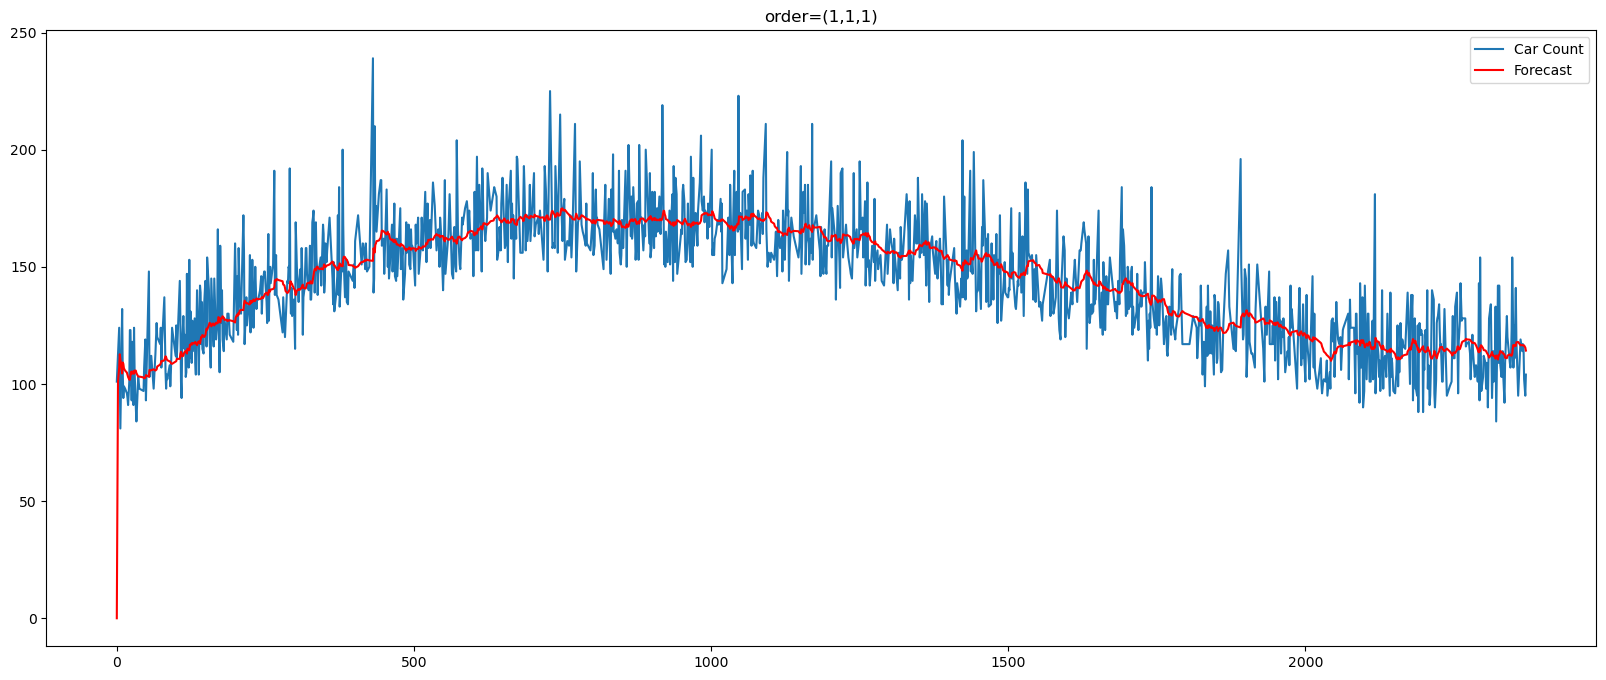

In [114]:
fig = plt.figure(figsize=(20,8))
model = sm.tsa.arima.ARIMA(clear_data['car_count_float'], order=(1,1,1))
ax = plt.gca()
results = model.fit()
plt.plot(clear_data['car_count'])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Car Count', 'Forecast'])
plt.title('order=(1,1,1)')


In [115]:
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:        car_count_float   No. Observations:                 1353
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5598.509
Date:                Thu, 24 Apr 2025   AIC                          11203.017
Time:                        16:21:14   BIC                          11218.645
Sample:                             0   HQIC                         11208.870
                               - 1353                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0017      0.030     -0.058      0.954      -0.060       0.057
ma.L1         -0.9361      0.010    -89.393      0.000      -0.957      -0.916
sigma2       230.9922      6.691     34.525      0.0

In [113]:
# Your time series (assumed already differenced if needed)
y = clear_data['car_count_float']

# Parameter ranges
p = range(0, 4)
d = range(0, 2)
q = range(0, 4)

best_aic = np.inf
best_order = None
best_model = None

# Grid search over (p,d,q)
for i in p:
    for j in d:
        for k in q:
            try:
                model = ARIMA(y, order=(i,j,k)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (i,j,k)
                    best_model = model
            except:
                continue

print(f"Best ARIMA order: {best_order}")
print(f"Best AIC: {best_aic}")

Best ARIMA order: (2, 1, 1)
Best AIC: 11200.446904370483
